In [2]:
!pip install -qq darts

In [ ]:
!pip install matplotlib==3.1.3

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

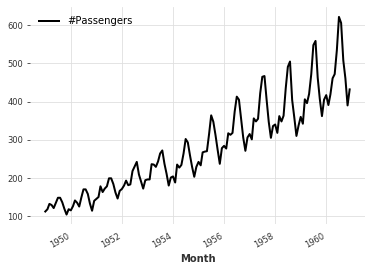

In [2]:
series = AirPassengersDataset().load()
series.plot()

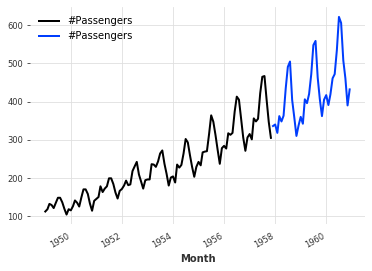

In [3]:
# Splitting
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

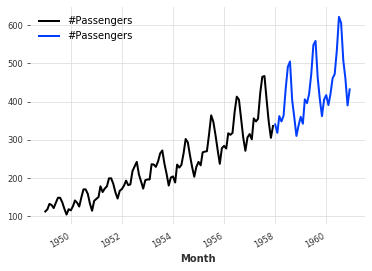

In [4]:
# Slicing
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

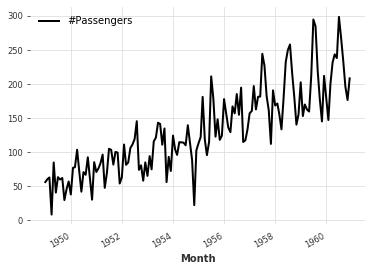

In [5]:
# Arithmetic Operations
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

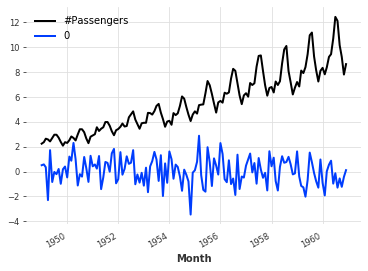

In [6]:
# Stacking
(series / 50).stack(series_noise).plot()

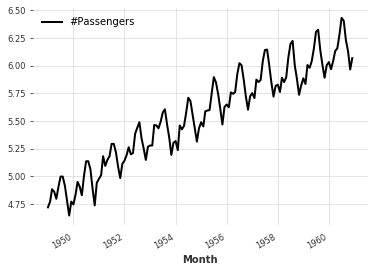

In [7]:
# Mapping
series.map(np.log).plot()

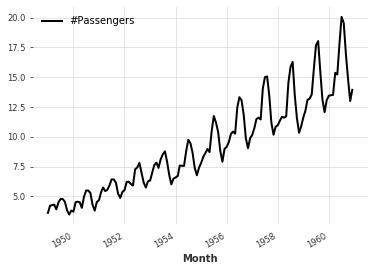

In [8]:
# Mapping on time stamps and values
series.map(lambda ts, x: x / ts.days_in_month).plot()

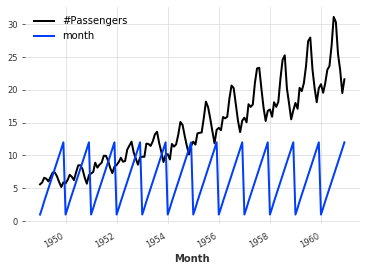

In [9]:
# Adding extra dimensions
(series / 20).add_datetime_attribute("month").plot()

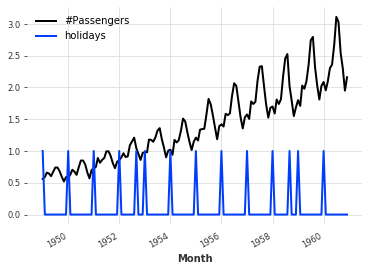

In [10]:
# Add binary holidays
(series / 200).add_holidays("US").plot()

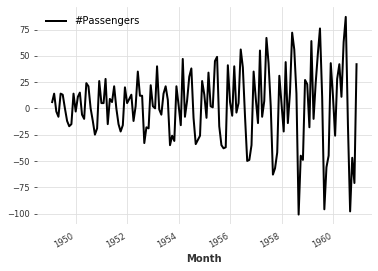

In [11]:
# Differencing
series.diff().plot()

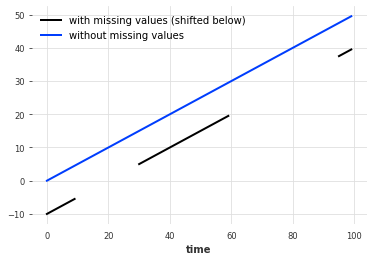

In [12]:
# Adding missing values
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

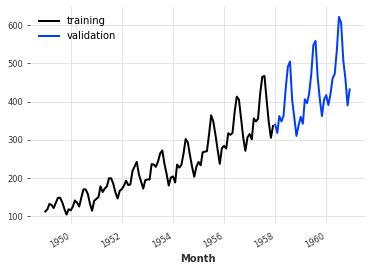

In [13]:
# Creating a training and validation set
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

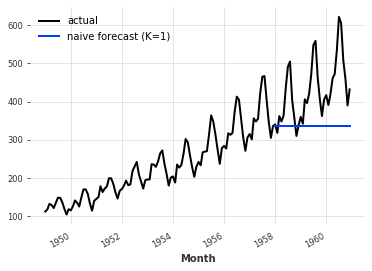

In [14]:
# Forecasting
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

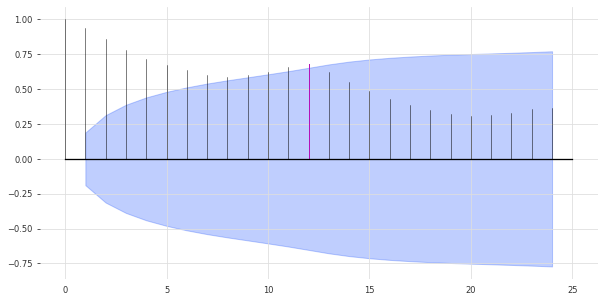

In [15]:
# Inspect seasonality
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [16]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


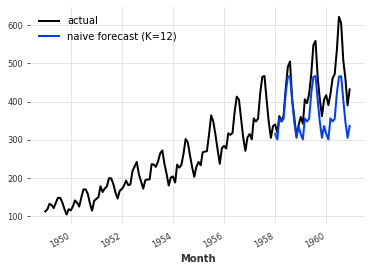

In [17]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

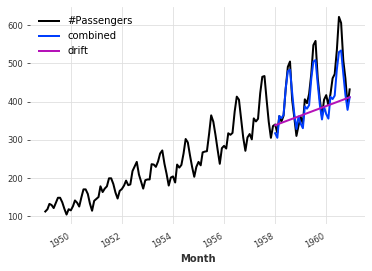

In [18]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [19]:
# Error metrics
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [20]:
# Compare models
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model (T)BATS obtains MAPE: 5.87%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


In [21]:
# Best hyperparameter with theta
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


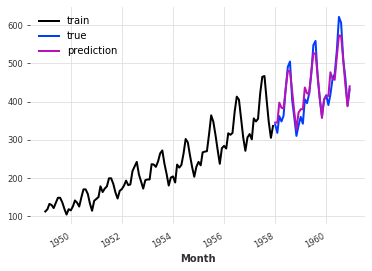

In [22]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

100%|██████████| 57/57 [00:01<00:00, 32.57it/s]


MAPE = 7.70%


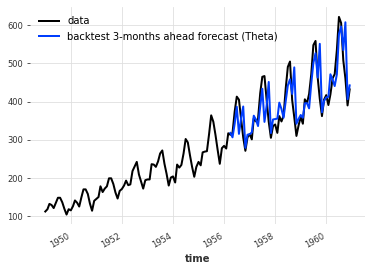

In [23]:
# Simulate historical forecasting
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

100%|██████████| 57/57 [00:04<00:00, 11.95it/s]


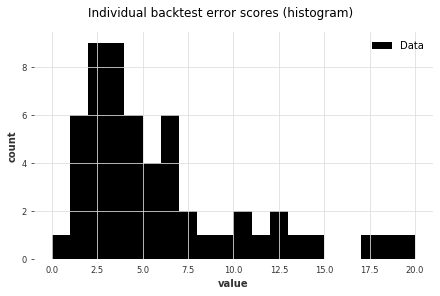

In [24]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [25]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

100%|██████████| 57/57 [00:01<00:00, 33.34it/s]


Average error (MAPE) over all historical forecasts: 6.36


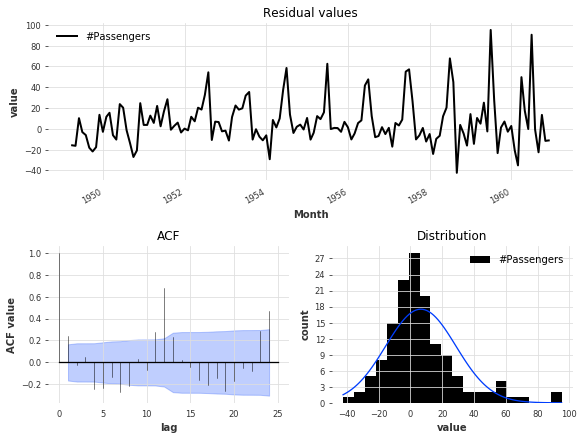

In [26]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

100%|██████████| 57/57 [00:08<00:00,  6.58it/s]


MAPE = 4.45%


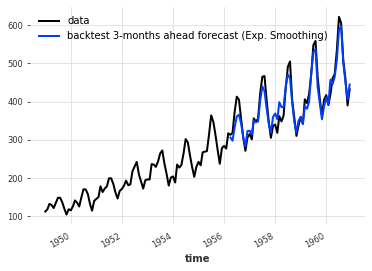

In [27]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

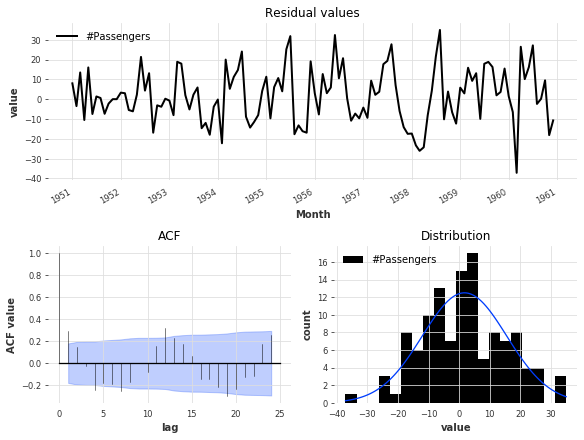

In [28]:
plot_residuals_analysis(model_es.residuals(series))

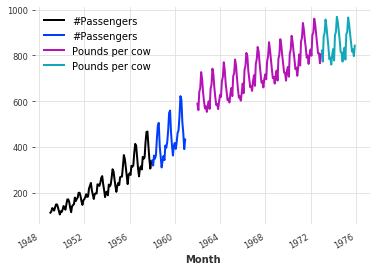

In [29]:
# Two time series models
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

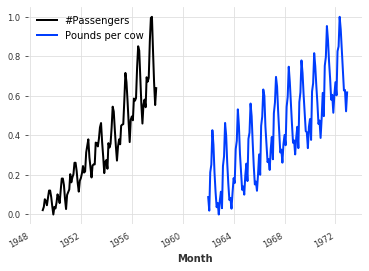

In [30]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [31]:
# Deep Learning model
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

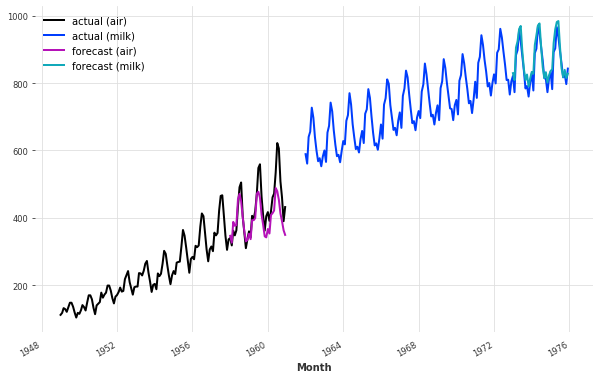

In [32]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

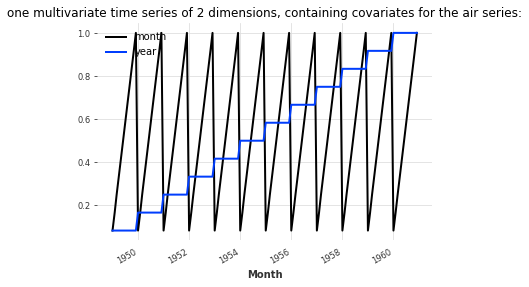

In [33]:
# Covariates with external data
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [34]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

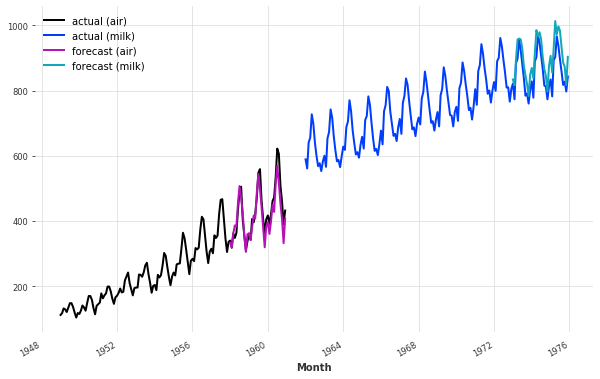

In [35]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [37]:
# Using encoders
encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [lambda idx: (idx.year - 1950) / 50]},
    "transformer": Scaler(),
}
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [38]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

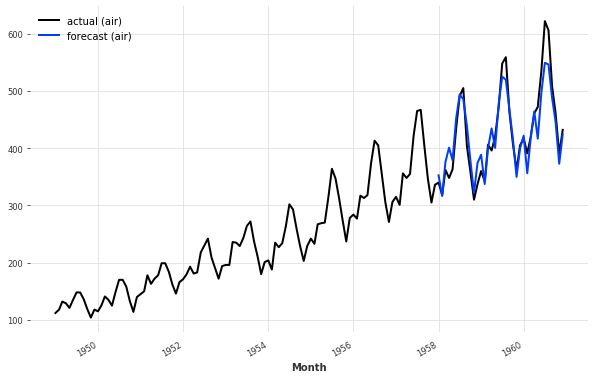

In [39]:
pred_air = model.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [40]:
# Regression forecasting model
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

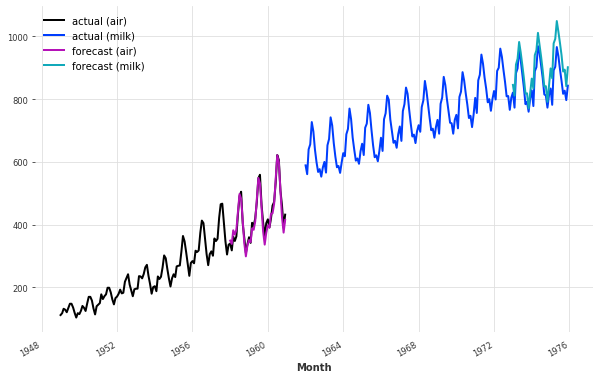

In [41]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [42]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.4172054919448454, 5.283041687692779]

In [43]:
mape([series_air, series_milk], [pred_air, pred_milk], inter_reduction=np.mean)

4.350123589818812

100%|██████████| 57/57 [00:06<00:00,  8.99it/s]


MAPE = 3.66


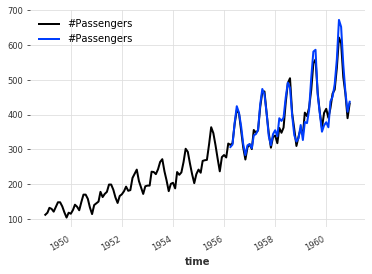

In [44]:
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

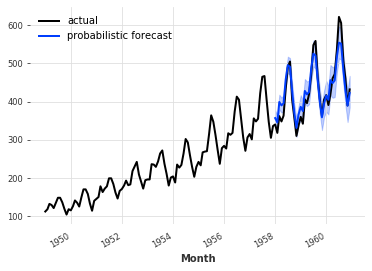

In [45]:
# Probabilistic forecast
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [46]:
# Probabilistic forecast with NN
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Predicting: 3it [00:00, ?it/s]

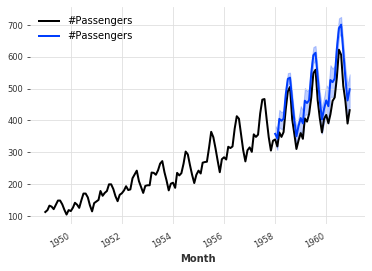

In [47]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

In [48]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Predicting: 3it [00:00, ?it/s]

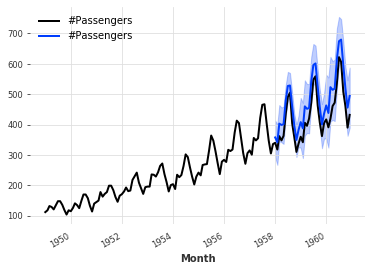

In [49]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

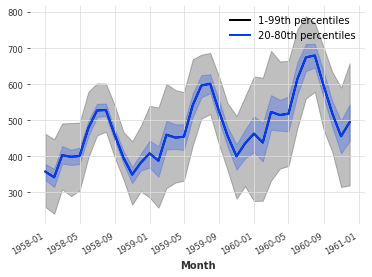

In [50]:
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

In [51]:
from darts.metrics import rho_risk

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

MAPE of median forecast: 11.82
rho-risk at quantile 0.05: 0.14
rho-risk at quantile 0.10: 0.15
rho-risk at quantile 0.50: 0.12
rho-risk at quantile 0.90: 0.03
rho-risk at quantile 0.95: 0.02


In [52]:
# Using quantile loss
from darts.utils.likelihood_models import QuantileRegression

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 208   
----------------------------------------------------
208       Trainable params
0         Non-trainable params
208       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Predicting: 3it [00:00, ?it/s]

MAPE of median forecast: 4.94
rho-risk at quantile 0.05: 0.00
rho-risk at quantile 0.10: 0.00
rho-risk at quantile 0.50: 0.03
rho-risk at quantile 0.90: 0.01
rho-risk at quantile 0.95: 0.01


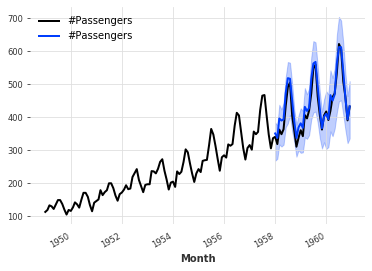

In [53]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

100%|██████████| 57/57 [00:01<00:00, 45.57it/s]


MAPE = 11.88


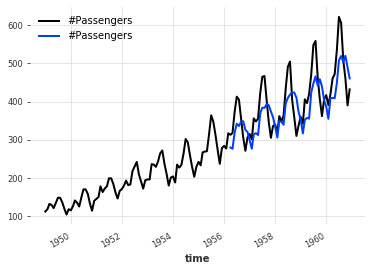

In [54]:
# Naive ensemble
from darts.models import NaiveEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = NaiveEnsembleModel(models=models)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

100%|██████████| 57/57 [00:02<00:00, 23.57it/s]


MAPE = 4.85


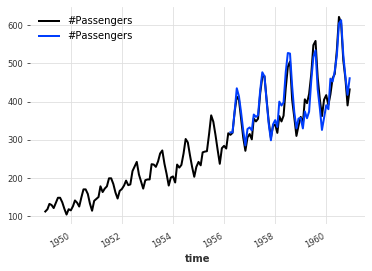

In [55]:
# Learned ensemble
from darts.models import RegressionEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

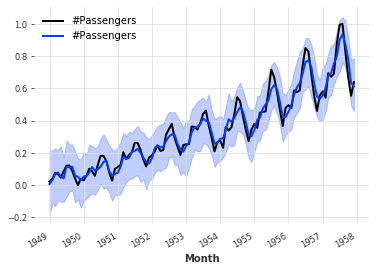

In [56]:
# Kalman filter
from darts.models import KalmanFilter

kf = KalmanFilter(dim_x=3)
kf.fit(train_air_scaled)
filtered_series = kf.filter(train_air_scaled, num_samples=100)

train_air_scaled.plot()
filtered_series.plot()

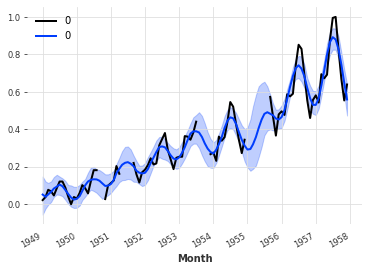

In [57]:
# Inferring missing values with Gaussian
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF

# create a series with holes:
values = train_air_scaled.values()
values[20:22] = np.nan
values[28:32] = np.nan
values[55:59] = np.nan
values[72:80] = np.nan
series_holes = TimeSeries.from_times_and_values(train_air_scaled.time_index, values)
series_holes.plot()

kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(series_holes, num_samples=100)

filtered_series.plot()